# Improving Machine Learning Experience With Multimedia Techniques
Marco A. Franchi

## *Abstract*

*It has been very common face machine learning algorithms at the multimedia area: traffic count; real-time vigilance cameras; baggage tracker; face/expression recognition; and so on. It is so common that it was designed a name for it, Machine Vision. However, it is perceptive the gap between machine learning and multimedia solutions, where even at simple embedded systems it is possible to reach 4k videos running at 60 frames per second, whereas the best neural network solution only handles 224x224 frames at 300 milliseconds in the same system. Due to this gap, a vast number of solutions as being developed: dedicated hardware for inference process; model manipulation; accelerated pre-processing image solutions; and video manipulation techniques. This paper is based at the study of these videos manipulation techniques, exposing the most common algorithmics, such as frame-skip, frame-droop, resizing, color convert, and overlay solutions; and showing the main difference between them, when the solution can be applied, and the expected performance for each one.*



## Introduction

Aiming to diminish the gap between the machine learning inference process and the multimedia capability, which reaches 4k@60fps, some video manipulation solutions was purposed. Among them, the most common is the overlay solutions, which are able to create alpha layers over the video and insert information on it. These overlays are very common on object detections algorithmics, once they are responsible for drawing a square, select or color an object at the scene. The most common overlays are Scalable Vector Graphics (SVG), Cairo, and OpenCV.
In addition to the overlays, it is important to use a great video framework able to handle all the elements involved at the inference and display solutions. One of the best and most useful ones is the GStreamer framework. GStreamer is able to handle plugins in pipelines, which is perfect to do quick tests.
Apart from the video solutions, it is important to choose the best machine learning algorithmics as well. With a focus on object detection, the most common and valued ones are Single Shot Detection (SSD) and Tensorflow. Both have an incredible inference process capability and the TFlite version demonstrated a great tool for embedded systems.
Thus, with all the tools chosen, this paper intends to compare the combination of theses algorithmics for object detection solutions. This comparison aims to demonstrate how we can increase the video frame rate with simple approaches and demonstrate the best scenarios to handle each neural network algorithmics and the overlays plugins behavior on these tests.

## Materials and Methods

This section describes the material such as the video files, models, labels, and programming language used, and the adopted methodology.

### Programming Language

This paper uses Python 3 language and all the required support for the object detection algorithm: the overlays libs, GStreamer plugins, Tensorflow Lite, and SSD.
* **OpenCV**: Open Source Computer Vision Library, this library is cross-platform and free for user under open-source BSD license. 
* **SVG image**: Scalable Vector Graphics, a Extensible Markup Language (XML)-based vector image format for two-dimensional graphics.  
* **Cairo**: Cairo is a 2D graphics library with support for multiples output devices and is available under LGPLv2.1 license.
* **GStreamer**: GStreamer is a library for constructiong graphics of media-handling components and is released under the LGPL license.
* **TFLite**: Tensoflow is a library for dataflow and differenctiable programming across of tasks, free and open-source under the Apache License 2.0. TFLite is a special version for mobile development. 
* **SSD**: Single Shot Detector algorithm designed for object detection in real-time applications.

### Models and Labels

As the focus of this paper is the video techniques, and as the SSD and TFlite already have a huge numbers of pre-processed models, this paper will not care about pre-processing or training models and will uses pre-processed models available at the TFLite official object detection support web page.

For this, the following pre-tested model and labels will be used at the tests:

**Model**: mobilenet_ssd_v2_coco_quant_postprocess.tflite

**Labels**: coco_labels.txt

### GStreamer and V4L2

As mentioned before, this paper uses GStreamer framework to reproduce the videos files.
For the comparison purpose, the following approaches will be performed:
* OpenCV V4L2 directly handle;
* GStreamer appsink pipeline + OpenCV V4L2 output;
* GStreamer appsink + appsrc pipelines;
* GStreamer overlay plugins support.

The workflow below describes the difference between each process:

### Workflow

**OpenCV V4L2 directly handle:**
![opencv](../data/images/opencv_v4l2.png)
For this approach, the OpenCV needs to handle the entire process: open the video, get the frame, resize and do a color convert on it, draw the informations at the frame, and display the results.
This is easely to test, but not fast for ML purpose, once the entire process will be depent from OpenCV.

The following code demonstrate the OpenCV V4L2 use case:

In [ ]:
from ObjectDetection import ObjectsDetectionOpenCV


def main():
    app = ObjectsDetectionOpenCV()
    app.run()


if __name__ == '__main__':
    main()

**GStreamer appsink pipeline + OpenCV V4L2 output**
![appsink](../data/images/appsink_opencv_v4l2.png)
This idea shows a better perfomance than OpenCV V4L2 due the GStremaer usage at the video openning process. It represents one less action to be processed by the OpenCV, and the GStreamer pipelines enables a vast number of plugins and its properties, which can guarantee some aditional chacateristics, such as dropping frame property.
It means that the displayed frame rate will not be impacted for the inference process time. However, the videoconvert usage, required for the appsink to be able to display the results at screen, is a disavantage, once its only supported by CPU, and resize/color convert by CPU has a high processing coast.

The following code demonstrate this use case:

In [ ]:
from ObjectDetection import ObjectsDetectionV4L2


def main():
    app = ObjectsDetectionV4L2()
    app.run()


if __name__ == '__main__':
    main()

**GStreamer appsink + appsrc pipelines**
![appsink/appsrc](../data/images/appsink_appsrc.png)
This combination shows very promissor, once we can use the appsink dropping frame property, but do not requires videoconvert, once its results will not be displayed yet. Actually, the resulted data will be processed by the inference process, which can include resizing and color convert, and the results will be send again to GStreamer, only to handle it and display at the screen.

The following code demonstrate this use case:

In [ ]:
from ObjectDetection import ObjectsDetectionAppsrc


def main():
    app = ObjectsDetectionAppsrc()
    app.run()


if __name__ == '__main__':
    main()

**GStreamer overlay plugins support:**
![overlay](../data/images/gstreamer_overlay.png)

This is the best approach, but the most dificult to use. Here, the tee usage create two threads: one to be processed by the inference process; other to be displayed. The videobox keeps the frame and is able to return it ot the overlay plugin, so what we see is the combination of two frames, one is the original video, without be touched, other is an alpha image with all the required resizing process being displayed over the original video.

The following code demonstrate this use case:

In [ ]:
from ObjectDetection import ObjectsDetectionGStreamer

def main():
    app = ObjectsDetectionGStreamer()
    app.run()


if __name__ == '__main__':
    main()

## Results

The examples were made to return the FPS and inference time average collected during the video playback process. With this values, two graphs were generated: one showing the FPS per each example, other showing the Inference time per each example.

The code below generates de values to compose the graphs:

In [1]:
from ObjectDetection import ObjectsDetectionOpenCV
from ObjectDetection import ObjectsDetectionGStreamer

fps = []
inf = []

opencv = ObjectsDetectionOpenCV()
inf_opencv, fps_opencv = opencv.run()

fps.append(fps_opencv)
inf.append(inf_opencv)

#V4L2 is still not working, so I am simulating a value
fps.append(1.5)
inf.append(490)

#APPSRC is still not working, so I am simulating a value
fps.append(2.25)
inf.append(467)

gstreamer = ObjectsDetectionGStreamer()
inf_gstreamer, fps_gstreamer = gstreamer.run()

fps.append(fps_gstreamer)
inf.append(inf_gstreamer)

Inference time: 0:00:00.471017
1.823114396716533
Inference time: 0:00:00.586821
1.624990069685684
Inference time: 0:00:00.470839
2.030042151247117
Inference time: 0:00:00.465317
2.090743149195542
Inference time: 0:00:00.466108
2.1007041831412727
Inference time: 0:00:00.471448
2.0683463114135714
Inference time: 0:00:00.478862
2.04182322873744
Inference time: 0:00:00.470132
2.074800134243718
Inference time: 0:00:00.470339
2.079438402244539
Inference time: 0:00:00.478474
2.0403286130412486
Inference time: 0:00:00.469643
2.080817711420963
Inference time: 0:00:00.471707
2.069075369447063
Inference time: 0:00:00.476293
2.050363892022392
Inference time: 0:00:00.471184
2.0747048089250812
Inference time: 0:00:00.472861
2.06630704507325
Inference time: 0:00:00.473493
2.0660335776446273
Inference time: 0:00:00.469347
2.079033121862539
Inference time: 0:00:00.471450
2.0738097766958132
Inference time: 0:00:00.472920
2.068800419834082
Inference time: 0:00:00.473172
2.066048005257613
Inference time: 

Inference time: 0:00:00.467909
2.087890650552193
Inference time: 0:00:00.474647
2.0648950679175995
Inference time: 0:00:00.462886
2.115876863964532
Inference time: 0:00:00.471290
2.0740103328231787
Inference time: 0:00:00.469333
2.080500398294117
Inference time: 0:00:00.467140
2.089008385739242
Inference time: 0:00:00.465900
2.095353854558472
Inference time: 0:00:00.471976
2.076522965290161
Inference time: 0:00:00.472810
2.0755575983931416
Inference time: 0:00:00.462772
2.1135641253770467
Inference time: 0:00:00.463542
2.1064200436938503
Inference time: 0:00:00.465659
2.1036153671913005
Inference time: 0:00:00.463191
2.110899040577177
Inference time: 0:00:00.462038
2.1216832306865463
Inference time: 0:00:00.462748
2.111213232371795
Inference time: 0:00:00.469147
2.08357905675676
Inference time: 0:00:00.463334
2.1142807030779998
Inference time: 0:00:00.471819
2.079208158357051
Inference time: 0:00:00.465279
2.100460527861148
Inference time: 0:00:00.463753
2.1147106566916527
Inference ti

Inference time: 0:00:00.471895
2.0418599753358015
Inference time: 0:00:00.470373
2.0735956718982167
Inference time: 0:00:00.475547
2.055101817389012
Inference time: 0:00:00.495549
1.9735880591338533
Inference time: 0:00:00.612460
1.5724326862834155
Inference time: 0:00:00.610880
1.6090416918406603
Inference time: 0:00:00.476902
2.0490762616678913
Inference time: 0:00:00.495724
1.9711856497180078
Inference time: 0:00:00.518587
1.890102485893031
Inference time: 0:00:00.515412
1.8897360554628462
Inference time: 0:00:00.534694
1.835009569923559
Inference time: 0:00:00.521131
1.8775799650276324
Inference time: 0:00:00.494431
1.9726473429578508
Inference time: 0:00:00.526748
1.8647620936427693
Inference time: 0:00:00.472379
2.0708346340159385
Inference time: 0:00:00.513388
1.9060117292950323
Inference time: 0:00:00.466954
2.0985659623677133
Inference time: 0:00:00.506532
1.9311578754894998
Inference time: 0:00:00.477862
2.0511346052079897
Inference time: 0:00:00.469859
2.0773197738916362
Inf

The code below generates de FPS graph:

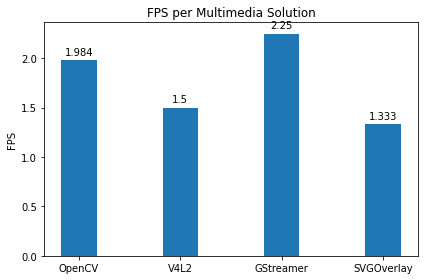

In [3]:
from ObjectDetection import graphs

fps_g = graphs()
fps_g.start(fps, 'FPS')

The code below generates de Inference graph:

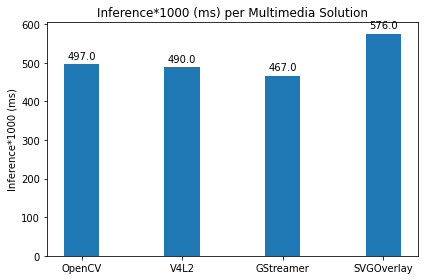

In [6]:
from ObjectDetection import graphs

inf_g = graphs()
inf_g.start(inf, 'Inference*1000 (ms)')

## Conclusion

Unfortunately, the object detection algorithms consume a lot of process resources, and the notebooks have no performance enough to handle it. However, it was still able to show the difference at the inference time and the framerate, both running together and consuming the same CPU process.
According to the values obtained, noticed that the number of about 0.5 milliseconds is far from the expected for a video object detection solution. With some simples calculations, it is easy to note that 0.5 ms of inference time represents 2 frames being calculated per second. It is very slow and it is far from the multimedia capabilities, which can achieve 60 frames per second. 

## Source

Martín Abadi, Paul Barham, Jianmin Chen, Zhifeng Chen, Andy Davis, Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Geoffrey Irving, Michael Isard, et al. 2016. TensorFlow: A System for Large-Scale Machine Learning.

Ganesh Ananthanarayanan, Paramvir Bahl, Peter Bodík, Krishna Chintalapudi, Matthai Philipose, Lenin Ravindranath, and Sudipta Sinha. 2017. Real-Time Video Analytics: The Killer App for Edge Computing.

Google. 2019. Coral Edge TPU. Retrieved June 16, 2020, from https://coral.ai/

Nvidia. 2020. NVIDIA DeepStream SDK. Retrieved June 16, 2020 from https://developer.nvidia.com/deepstream-sdk

GStreamer. 2019. GStreamer: open source multimedia framework. Retrieved June 16, 2020 from https://gstreamer.freedesktop.org

Intel. 2020.03. Intel's Deep Learning Inference Engine Developer Guide. Retrieved June 16, 2020 from https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html
